## This project will be working on recognizing and accuratley analyzing facial expressions


In [1]:
#import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm
import cv2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#defining standard image shape
Image_Width=125
Image_height=125
Image_size=(Image_Width,Image_height)
Image_Channels=3

In [4]:
#unzip file
!unzip facial_expression.zip

Streaming output truncated to the last 5000 lines.
 extracting: facial_expression/Training/Sad/Sad-370.jpg  
 extracting: facial_expression/Training/Sad/Sad-3700.jpg  
 extracting: facial_expression/Training/Sad/Sad-3701.jpg  
 extracting: facial_expression/Training/Sad/Sad-3702.jpg  
 extracting: facial_expression/Training/Sad/Sad-3703.jpg  
 extracting: facial_expression/Training/Sad/Sad-3704.jpg  
 extracting: facial_expression/Training/Sad/Sad-3705.jpg  
 extracting: facial_expression/Training/Sad/Sad-3706.jpg  
 extracting: facial_expression/Training/Sad/Sad-3707.jpg  
 extracting: facial_expression/Training/Sad/Sad-3708.jpg  
 extracting: facial_expression/Training/Sad/Sad-3709.jpg  
 extracting: facial_expression/Training/Sad/Sad-371.jpg  
 extracting: facial_expression/Training/Sad/Sad-3710.jpg  
 extracting: facial_expression/Training/Sad/Sad-3711.jpg  
 extracting: facial_expression/Training/Sad/Sad-3712.jpg  
 extracting: facial_expression/Training/Sad/Sad-3713.jpg  
 extrac

'/content'

In [5]:
#checking count of images
for exp in os.listdir("./facial_expression/Training"):
  print(str(len(os.listdir("./facial_expression/Training/" + exp)))+ " "+ exp+ " total images")

3171 Suprise total images
4965 Neutral total images
4097 Fear total images
3995 Angry total images
4830 Sad total images
7215 Happy total images


In [6]:
#creating access to data sets
datasets = ['./facial_expression/Training','./facial_expression/Testing']
output = []
class_names = ['Angry','Fear','Happy','Neutral','Sad','Suprise']
class_name_labels = {class_name:j for j,class_name in enumerate(class_names)}
nb_classes = len(class_names)
class_name_labels

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Suprise': 5}

In [7]:
#Function to load data
def load_data():
    for dataset in datasets:
        print("Loading {}".format(dataset))
        images,labels = [],[]
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                img_path = os.path.join(os.path.join(dataset,folder),file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img,(125,125))
                images.append(img)
                labels.append(label)
                pass
            pass
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        output.append((images,labels))
        pass
    return output
    pass

In [8]:
(train_images, train_labels),(test_images, test_labels) = load_data()

 19%|█▉        | 617/3171 [00:00<00:00, 6164.23it/s]

Loading ./facial_expression/Training


 87%|████████▋ | 1072/1233 [00:00<00:00, 10710.92it/s]

Loading ./facial_expression/Testing


100%|██████████| 1774/1774 [00:00<00:00, 10706.78it/s]


In [9]:
#setting up data frame
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
_, train_count = np.unique(train_labels,return_counts=True)
_, test_count = np.unique(test_labels,return_counts=True)
df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = class_names
df

,0,1,Name
0,3995,958,Angry
1,4097,1024,Fear
2,7215,1774,Happy
3,4965,1233,Neutral
4,4830,1247,Sad
5,3171,831,Suprise


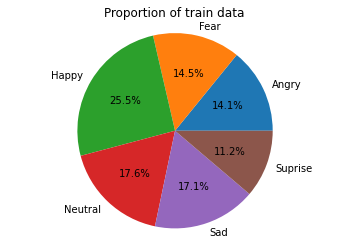

In [10]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0),
       labels=class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of train data")
plt.show()

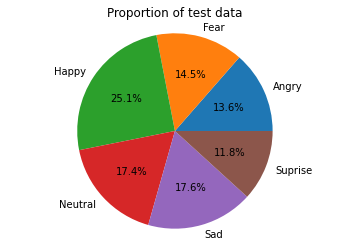

In [11]:
plt.pie(test_count,
       explode=(0,0,0,0,0,0),
       labels=class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of test data")
plt.show()

In [12]:

batch_size = 64
datagen_train = ImageDataGenerator(rescale = 1./255)
datagen_test = ImageDataGenerator(rescale = 1./255)
train_generator = datagen_train.flow_from_directory("./facial_expression/Training",
                                                   target_size = Image_size,
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode = "categorical",
                                                   shuffle=True)
test_generator = datagen_test.flow_from_directory("./facial_expression/Testing",
                                                 target_size = Image_size,
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=True)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [13]:
#additional keras imports
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Sequential,Input,Model

from keras.initializers import *

In [14]:
#functions to build CNN
def identity_block(X,k,filters,stage,block):
    conv_name_base = 'res_'+str(stage)+block+'_branch'
    bn_name_base = 'bn_'+str(stage)+block+'_branch'
    F1,F2,F3 = filters
    X_shortcut = X
    # First Component of Main Path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(1,1),
               padding='same',name=conv_name_base+'2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    # Second Component of Main Path
    X = Conv2D(filters=F2,kernel_size=(k,k),strides=(1,1),
              padding='same',name=conv_name_base+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    # Third Component of Main Path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_name_base+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2c')(X)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    return X
    pass

def convolutional_block(X,k,filters,stage,block,s=2):
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    F1,F2,F3 = filters
    X_shortcut = X
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(s,s),
              padding='same',name=conv_base_name+'2a',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    # Second Component of main path
    X = Conv2D(filters=F2,kernel_size=(k,k),strides=(1,1),
              padding='same',name=conv_base_name+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2b')(X)
    X = Activation('relu')(X)
    # Third Component of main path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_base_name+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2c')(X)
    # Shortcut path
    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),
                       padding='same',name=conv_base_name+'1',
                       kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_base_name+'1')(X_shortcut)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    return X
    pass

def ResNet(input_shape,classes):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input)
    # Stage 1
    X = Conv2D(64,(3,3),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3))(X)
    # Stage 2
    X = convolutional_block(X,k=3,filters=[32,32,64],stage=2,block='A',s=1)
    X = identity_block(X,k=3,filters=[32,32,64],stage=2,block='B')
    X = identity_block(X,k=3,filters=[32,32,64],stage=2,block='C')
    # Stage 3
    X = convolutional_block(X,k=3,filters=[64,64,128],stage=3,block='A',s=1)
    X = identity_block(X,k=5,filters=[64,64,128],stage=3,block='B')
    X = identity_block(X,k=3,filters=[64,64,128],stage=3,block='C')
    X = identity_block(X,k=5,filters=[64,64,128],stage=3,block='D')
    # Stage 4
    X = convolutional_block(X,k=5,filters=[128,128,256],stage=4,block='A',s=1)
    X = identity_block(X,k=3,filters=[128,128,256],stage=4,block='B')
    X = identity_block(X,k=3,filters=[128,128,256],stage=4,block='C')
    X = AveragePooling2D((2,2),name='avg_pooling1')(X)
    X = Flatten()(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input,outputs=X,name='ResNet')
    return model
    pass

In [15]:
model = ResNet(input_shape=(125,125,1),classes=6)

In [16]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 125, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 131, 131, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 65, 65, 64)   640         zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 65, 65, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [17]:
opt = Adam(learning_rate=0.003)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]
epochs = 25
# batch_size = 128
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=50,
                             epochs=epochs,
                             validation_data=test_generator,
                             validation_steps = 50,
                             callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
50/50 [==============================] - 65s 241ms/step - loss: 16.2037 - accuracy: 0.1727 - val_loss: 1448897.0000 - val_accuracy: 0.1412

Epoch 00001: val_accuracy improved from -inf to 0.14125, saving model to model_weights.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
50/50 [==============================] - 9s 186ms/step - loss: 4.7109 - accuracy: 0.2192 - val_loss: 3727798.0000 - val_accuracy: 0.1728

Epoch 00002: val_accuracy improved from 0.14125 to 0.17281, saving model to model_weights.h5
Epoch 3/25
50/50 [==============================] - 9s 188ms/step - loss: 3.8284 - accuracy: 0.2387 - val_loss: 10388.0156 - val_accuracy: 0.1719

Epoch 00003: val_accuracy did not improve from 0.17281
Epoch 4/25
50/50 [==============================] - 9s 189ms/step - loss: 2.5967 - accuracy: 0.2425 - val_loss: 176.7363 - val_accuracy: 0.2422

Epoch 00004: val_accuracy improved from 0.17281 to 0.24219, saving model to model_weights.h5
Epoch 5/25
50/50 [==============================] - 9s 190ms/step - loss: 1.7975 - accuracy: 0.2797 - val_loss: 1.7646 - val_accuracy: 0.2503

Epoch 00005: val_accuracy improved from 0.24219 to 0.25031, saving model to model_weights.h5
Epoch 6/25
50/50 [==============================] - 10s 191ms/step - loss: 1.7192 

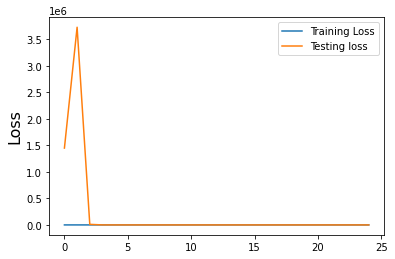

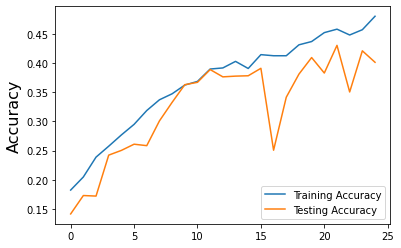

In [19]:
#looking at loss/accuracy plots
plt.figure()
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testing loss')
plt.legend(loc='upper right')

# plt.subplot(1,2,2)
plt.figure()
plt.ylabel('Accuracy',fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testing Accuracy')
plt.legend(loc='lower right')

plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 432x288 with 0 Axes>

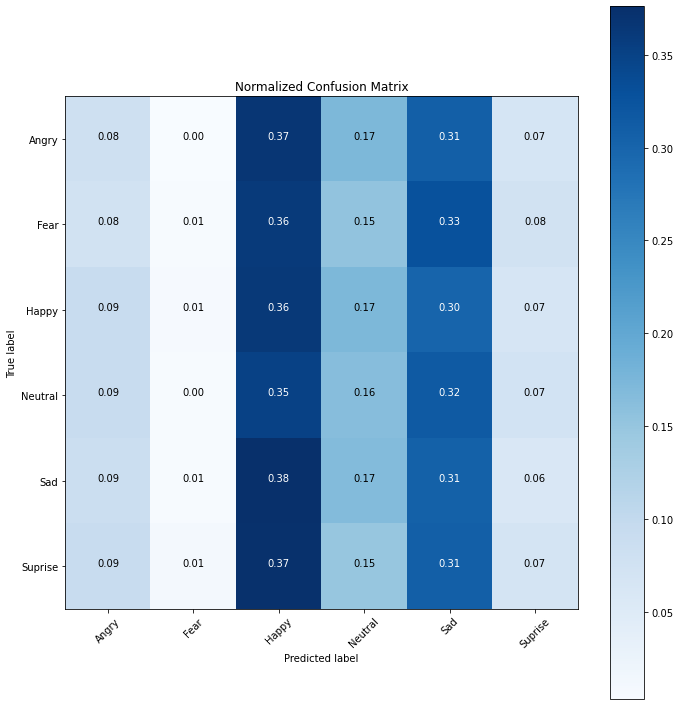

In [20]:
#confusion matrix
predictions = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion matirx',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names, title='Normalized Confusion Matrix')
plt.show()

In [21]:
#looking at test accuracy
test_acc = model.evaluate_generator(test_generator)
print("Test accuracy: ",test_acc[1])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test accuracy:  0.39550021290779114


## Now trying with higher number of steps using colab gpu

In [23]:
model = ResNet(input_shape=(125,125,1),classes=6)
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 125, 125, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 131, 131, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 65, 65, 64)   640         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 65, 65, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [24]:
opt = Adam(learning_rate=0.003)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]
epochs = 25
# batch_size = 128
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=train_generator.n//train_generator.batch_size,
                             epochs=epochs,
                             validation_data=test_generator,
                             validation_steps = test_generator.n//test_generator.batch_size,
                             callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
441/441 [==============================] - 69s 155ms/step - loss: 1.5646 - accuracy: 0.3711 - val_loss: 1.5382 - val_accuracy: 0.3943

Epoch 00001: val_accuracy improved from -inf to 0.39432, saving model to model_weights.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
441/441 [==============================] - 70s 158ms/step - loss: 1.3884 - accuracy: 0.4549 - val_loss: 1.4756 - val_accuracy: 0.4270

Epoch 00002: val_accuracy improved from 0.39432 to 0.42699, saving model to model_weights.h5
Epoch 3/25
441/441 [==============================] - 71s 161ms/step - loss: 1.2887 - accuracy: 0.5000 - val_loss: 1.3130 - val_accuracy: 0.4839

Epoch 00003: val_accuracy improved from 0.42699 to 0.48395, saving model to model_weights.h5
Epoch 4/25
441/441 [==============================] - 71s 161ms/step - loss: 1.2173 - accuracy: 0.5287 - val_loss: 1.2916 - val_accuracy: 0.5013

Epoch 00004: val_accuracy improved from 0.48395 to 0.50128, saving model to model_weights.h5
Epoch 5/25
441/441 [==============================] - 71s 161ms/step - loss: 1.1539 - accuracy: 0.5566 - val_loss: 1.4385 - val_accuracy: 0.4335

Epoch 00005: val_accuracy did not improve from 0.50128
Epoch 6/25
441/441 [==============================] - 71s 161ms/step - loss: 1.096

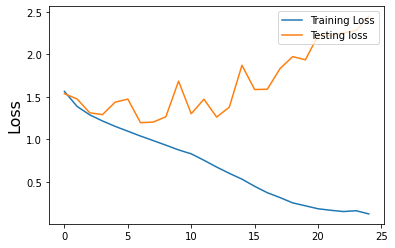

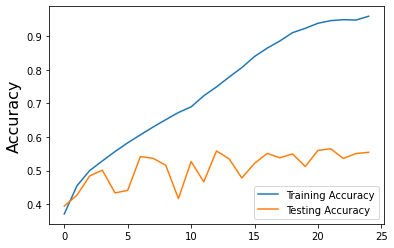

In [27]:
#looking at loss/accuracy plots
plt.figure()
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testing loss')
plt.legend(loc='upper right')

# plt.subplot(1,2,2)
plt.figure()
plt.ylabel('Accuracy',fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testing Accuracy')
plt.legend(loc='lower right')

plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 432x288 with 0 Axes>

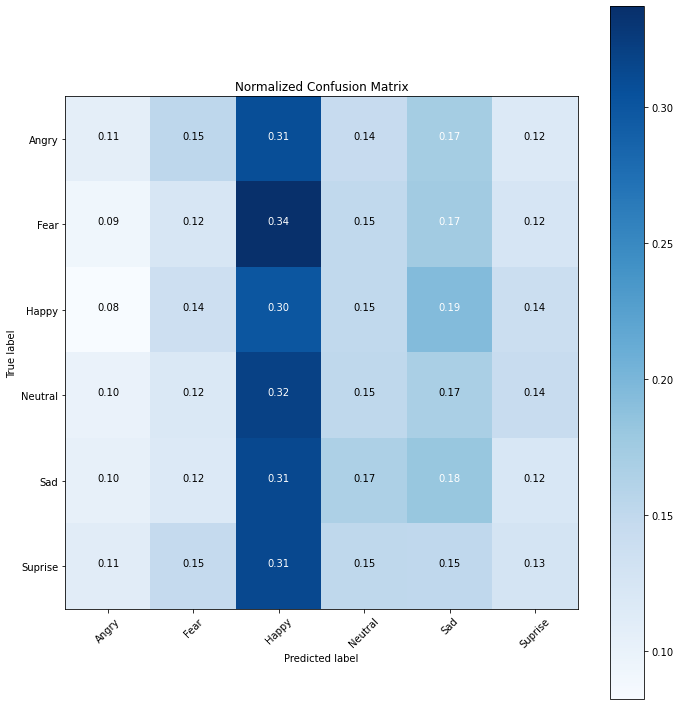

In [28]:
#confusion matrix
predictions = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion matirx',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names, title='Normalized Confusion Matrix')
plt.show()

In [29]:
#looking at test accuracy
test_acc = model.evaluate_generator(test_generator)
print("Test accuracy: ",test_acc[1])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test accuracy:  0.5538418292999268
